In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Import the dataset
df = pd.read_csv("/kaggle/input/uber-fares-dataset/uber.csv", index_col = [0])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


From a look at the dataset, we can tell:
* "key" is unique for each sample, thus useless.
* "fare_amount" is the one we are going to predict
* "pickup_datetime" is not in a number format, so its useless.
* day, month, hour and minute of time may play a role in the prediction.
* We might want to calculate straight distance between two locations so it will help to predict the cost, since we do not have access to the actual path it travelled.

**Data Preprocessing**

In [3]:
#Drop the rows where the latitude and longitude is not in range, as well as the nan values
condition = df[(df.pickup_longitude<-180) | (df.pickup_longitude>180) | (df.dropoff_longitude>180) | (df.dropoff_longitude<-180) | (df.pickup_latitude>90) | (df.pickup_latitude<-90) | (df.dropoff_latitude>90) | (df.dropoff_latitude<-90)].index
df.drop(condition, inplace=True)

df.dropna(inplace=True)

In [4]:
#Drop the "key"
df.drop(["key"], axis=1, inplace=True)

In [5]:
#extract pickup_datetime and find the day, month hour and minute from it
datetime = df["pickup_datetime"]
date = [x.split(sep=" ")[0] for x in datetime]
time = [x.split(sep=" ")[1] for x in datetime]
day = [x.split(sep="-")[-1] for x in date]
month = [x.split(sep="-")[1] for x in date]
hour = [x.split(sep=":")[0] for x in time]
minute = [x.split(sep=":")[1] for x in time]

In [6]:
#Calculate the distance
latitude, longitude = [], []

longitude.append(df["pickup_longitude"].tolist())
longitude.append(df["dropoff_longitude"].tolist())
latitude.append(df["pickup_latitude"].tolist())
latitude.append(df["dropoff_latitude"].tolist())

#Find the distance in meters
distance = [hs.haversine((latitude[0][i], longitude[0][i]), (latitude[1][i], longitude[1][i]), unit=Unit.METERS) for i in range(len(longitude[0]))]

In [7]:
#Drop datetime
df.drop(["pickup_datetime"], axis=1, inplace=True)
distance = pd.DataFrame({"distance": distance})
day = pd.DataFrame({"day": day})
month = pd.DataFrame({"month": month})
hour = pd.DataFrame({"hour": hour})
minute = pd.DataFrame({"minute": minute})

In [8]:

columns_extra = ["distance", "day", "month", "hour", "minute"]
df2 = pd.concat([distance, day, month, hour, minute], axis=1, ignore_index=True)
df2.columns = columns_extra
print(df2.head())

      distance day month hour minute
0  1683.325078  07    05   19     52
1  2457.593278  17    07   20     04
2  5036.384147  24    08   21     45
3  1661.685754  26    06   08     22
4  4475.456145  28    08   17     47


In [9]:
#Append the new columns to the dataset
columns = df.columns
df = df.reset_index(drop=True)
df.columns = columns
dataframe = pd.concat([df, df2], axis=1)
print(dataframe.head())

   fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude  passenger_count     distance day month hour minute  
0         40.723217                1  1683.325078  07    05   19     52  
1         40.750325                1  2457.593278  17    07   20     04  
2         40.772647                1  5036.384147  24    08   21     45  
3         40.803349                3  1661.685754  26    06   08     22  
4         40.761247                5  4475.456145  28    08   17     47  


**Fit data into model**

In [10]:
#create x and y sets
Y = dataframe["fare_amount"]
X = dataframe.drop(["fare_amount"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
#Create the model with standardizer and fit the model

scaler = StandardScaler()

sgdr = Pipeline([
    ('scalar', scaler),
    ('SGDR', SGDRegressor())
])
dtr = Pipeline([
    ('scalar', scaler),
    ('DTR', DecisionTreeRegressor())
])
lr = Pipeline([
    ('scalar', scaler),
    ('LR', LinearRegression())
])
svr = Pipeline([
    ('scalar', scaler),
    ('SVR', SVR())
])
lasso = Pipeline([
    ('scalar', scaler),
    ('Lasso', Lasso(alpha=0.1))
])
rfr = Pipeline([
    ('scalar', scaler),
    ('RFR', RandomForestRegressor(max_depth=3))
])

sgdr.fit(x_train, y_train)
dtr.fit(x_train, y_train)
lr.fit(x_train, y_train)
svr.fit(x_train, y_train)
lasso.fit(x_train, y_train)
rfr.fit(x_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('RFR', RandomForestRegressor(max_depth=3))])

In [15]:
#print the error for SGDR
print("SGDR:")
y_pred_sgdr = sgdr.predict(x_test)
mse = mean_squared_error(y_test, y_pred_sgdr)
rmse = np.sqrt(mse)
print(mse, " ", rmse)

#print the error for DTR
print("DTR:")
y_pred_dtr = dtr.predict(x_test)
mse = mean_squared_error(y_test, y_pred_dtr)
rmse = np.sqrt(mse)
print(mse, " ", rmse)

#print the error for LR
print("LR:")
y_pred_lr = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
print(mse, " ", rmse)

#print the error for SVR
print("SVR:")
y_pred_svr = svr.predict(x_test)
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
print(mse, " ", rmse)

#print the error for Lasso
print("Lasso:")
y_pred_lasso = lasso.predict(x_test)
mse = mean_squared_error(y_test, y_pred_lasso)
rmse = np.sqrt(mse)
print(mse, " ", rmse)

#print the error for RFR
print("RFR:")
y_pred_rfr = rfr.predict(x_test)
mse = mean_squared_error(y_test, y_pred_rfr)
rmse = np.sqrt(mse)
print(mse, " ", rmse)


SGDR:
91.60949033014843   9.571284675013509
DTR:
38.39560835541777   6.1964189945014025
LR:
91.58242436113056   9.569870655402328
SVR:
89.75510140711485   9.473916898892181
Lasso:
91.63958483623453   9.572856670620038
RFR:
26.462852531210363   5.144205724036546


It seems that the random forest has the least error, which will make it the best model

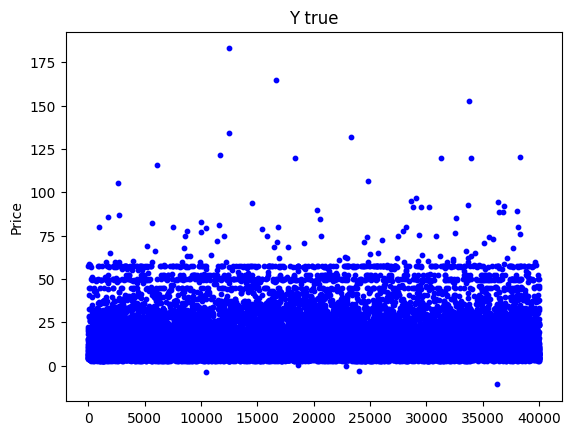

In [17]:
#Plot the true data

plt.scatter(index, y_test, s=10, c='blue')
plt.ylabel('Price')
plt.title('Y true')
plt.show()

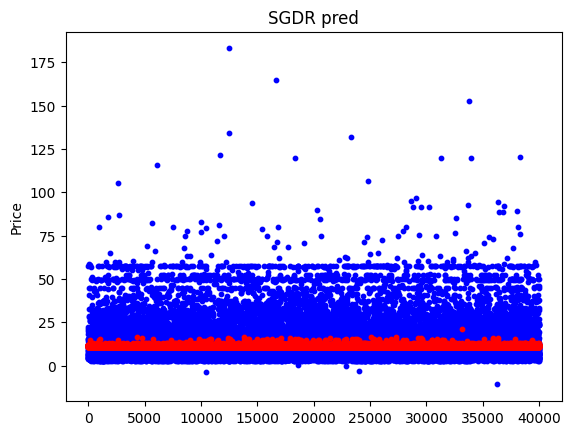

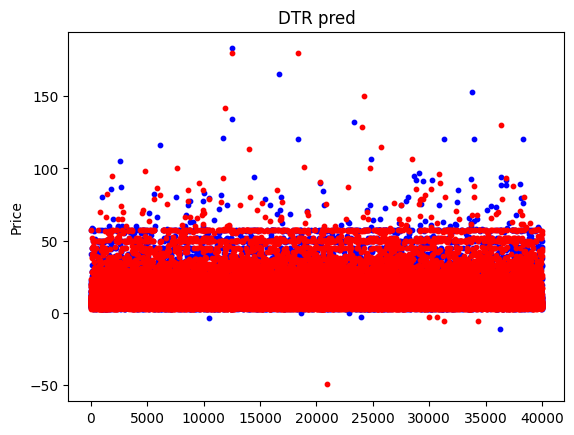

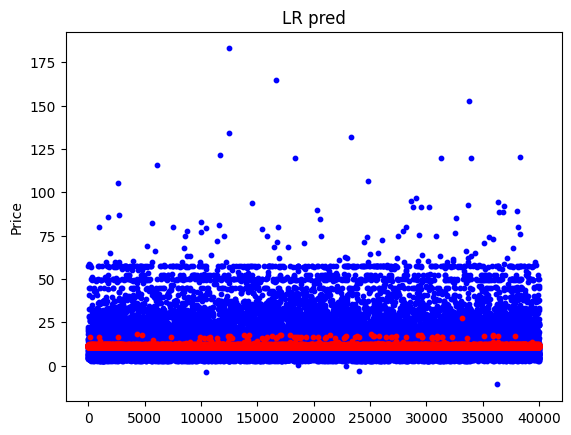

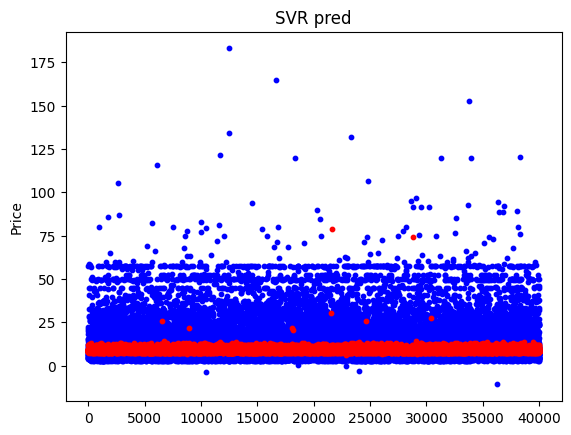

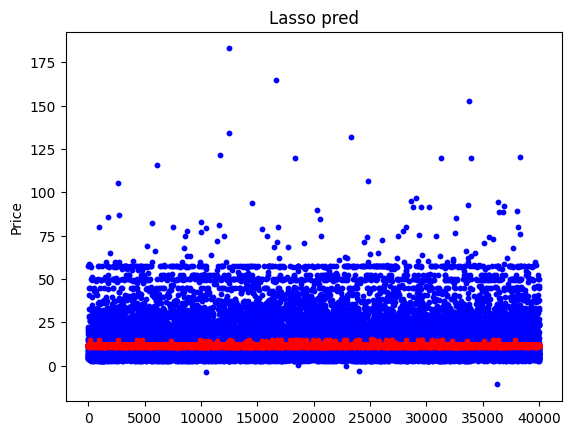

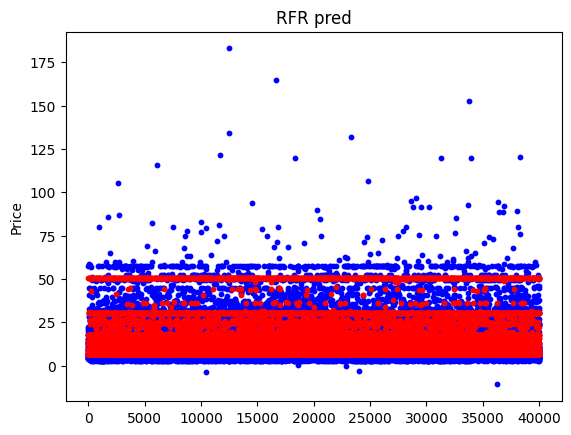

In [19]:
index = [np.arange(len(y_test))]

#Plot the data for SGDR

plt.scatter(index, y_test, s=10, c='blue')
plt.scatter(index, y_pred_sgdr, s=10, c='red')
plt.ylabel('Price')
plt.title('SGDR pred')
plt.show()

#Plot the data for DTR

plt.scatter(index, y_test, s=10, c='blue')
plt.scatter(index, y_pred_dtr, s=10, c='red')
plt.ylabel('Price')
plt.title('DTR pred')
plt.show()

#Plot the data for LR

plt.scatter(index, y_test, s=10, c='blue')
plt.scatter(index, y_pred_lr, s=10, c='red')
plt.ylabel('Price')
plt.title('LR pred')
plt.show()

#Plot the data for SVR

plt.scatter(index, y_test, s=10, c='blue')
plt.scatter(index, y_pred_svr, s=10, c='red')
plt.ylabel('Price')
plt.title('SVR pred')
plt.show()

#Plot the data for Lasso

plt.scatter(index, y_test, s=10, c='blue')
plt.scatter(index, y_pred_lasso, s=10, c='red')
plt.ylabel('Price')
plt.title('Lasso pred')
plt.show()

#Plot the data for RFR

plt.scatter(index, y_test, s=10, c='blue')
plt.scatter(index, y_pred_rfr, s=10, c='red')
plt.ylabel('Price')
plt.title('RFR pred')
plt.show()